# BM3D

Python implementation of ["An Analysis and Implementation of the BM3D Image Denoising Method" by Marc Lebrun](https://www.ipol.im/pub/art/2012/l-bm3d/?utm_source=doi).

## Modules

In [1]:
import numpy as np
from skimage import io as skio
import heapq
import pywt
import math
from scipy.linalg import hadamard
import cv2

# local
import matplotlib.pyplot as plt

## Parameters

In [2]:
# 1st step
kHard = 8  #patch size
nHard = 39 #search window size --! era pra ser 39 mas nao entendi como centralizar P
NHard = 16 #max number of similar patches kept 
pHard = 3

sigma = 30
tauHard = 5000 if sigma > 40 else 2500

lambdaHard2d = 0 #hard thresholding for grouping --! ??? where
lambdaHard3d = 2.7

In [3]:
# 2nd step

## Initialization

In [4]:
im = skio.imread('./lena.tif') # original image

In [5]:
def noise(im,br):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

In [6]:
imbr = noise(im, sigma) # create noisy image

## The First Denoising Step


### Grouping

In [7]:
# x,y is the top-left corner of the reference patch
# doesnt work well for even window_size --change
def get_search_window(image, x, y, patch_size=kHard, window_size=nHard):
    """ Given an image and the xy coordinates of the top-left corner of a reference patch
        Finds the search window with the reference patch in the center
        Returns the search window and the coordinates of its top-left pixel
    """
        
    window_top_left_x = x - (window_size//2 - patch_size//2)
    window_top_left_y = y - (window_size//2 - patch_size//2)
    
    search_window = image[
        window_top_left_x: window_top_left_x + window_size,
        window_top_left_y: window_top_left_y + window_size 
    ]
    return search_window, window_top_left_x, window_top_left_y

In [8]:
def hard_thresholding(img, threshold):
    """ Applies a hard thresholding operation to an array
    """
    return (abs(img) > threshold) * img

In [10]:
def distance(p,q):
    """ Calculates the normalized quadratic distance between two patches
    """
    return (np.linalg.norm(p-q) ** 2) / (kHard ** 2)

In [11]:
def closest_power_of_two(n, max_n):
    """ Returns the closest power of 2 to the number n, but not exceeding max_n.
    """
    if n == 0:
        return 0
    closest_pow2 = 2 ** (math.floor(math.log2(n)))
    return min(closest_pow2, max_n)

In [12]:
def build_3d_group(x, y, p, window, sigma, lambdaHard2d, tauHard, N=NHard):
    """
    """
    closer_N_dists = []

    # assumming square patch and window
    k = p.shape[0]
    n = window.shape[0] 

    if sigma > 40:
        p = hard_thresholding(p, lambdaHard2d * sigma)
    
    for i in range(n-k+1):
        for j in range(n-k+1):
            # get patch Q and calculate distance to ref P
            q = window[i:k+i, j:k+j]
            if sigma > 40:
                q = hard_thresholding(q, lambdaHard2d * sigma)
            
            dist = distance(p, q)
            #print(dist)
            if dist <= tauHard:
                dist_tuple = (-dist, (i, j))  # negate distance to use max-heap
        
                if len(closer_N_dists) < N:
                    heapq.heappush(closer_N_dists, dist_tuple)
                else:
                    if dist_tuple > closer_N_dists[0]:
                        heapq.heappushpop(closer_N_dists, dist_tuple)

    closer_N_dists = sorted([(-d, idx) for d, idx in closer_N_dists], key=lambda x: x[0])
    
    coords   = np.array([idx for d, idx in closer_N_dists]) + (x,y)
    group_3d = np.array([window[i:k+i, j:k+j] for d, (i, j) in closer_N_dists])

    N = len(group_3d)
    # check if its power of two and adjust if necessary
    if not (N & (N - 1)) == 0:
        group_size = closest_power_of_two(N, NHard)
        group_3d = group_3d[:group_size]
        coords = coords[:group_size]
    
    return group_3d, coords

After the grouping in 1st step, we get a list of tuples formed by: 
- a numpy array (N, 8, 8) where 1 <= N <= NHard (16), which represent a 3d group
- the indeces (i, j) of the reference patch linked to that 3d group 

DÚVIDA: como lidar com patches que não formam grupos? acho que quando nenhum Q teve distancia abaixo da threshold. por enquanto vou só ignorar eles 

limitar N a uma potencia de 2 quando nao chega a 16

do we keep the reference patch in its 3d group?

### Collaborative Filtering

After the grouping in 1st step, we have a list of tuples formed by: 
- a numpy array (N, 8, 8) where 1 <= N <= NHard (16), which represent a 3d group
- the indeces (i, j) of the reference patch linked to that 3d group 

In the Collaborative Filtering step, we will perform the following steps for each 3d group:
1. apply a 3D isometric linear transform to the 3d block
2. apply a hard thresholding operator with threshold $\lambda ^{hard} _{3D} \sigma$
3. apply the inverse linear transform
4. save in a buffer the estimate found for each pixel in each patch (this will later be used in the aggregation step)

This means that the reference patch of size kHard x kHard (8x8) and top-left pixel in (18,489) should be estimated according to the 16 8x8 patches in the 3d group stored in a[1000][0]. 

In [21]:
def apply_1d_transform(array, use_dct=False):
    #if use_dct:
     #   return cv2.dct(array)  # 2D DCT
    #else:
    return walsh_hadamard_transform(array) / np.sqrt(len(array)) #fwht(array)

def reverse_1d_transform(array, use_dct=False):
    #if use_dct:
     #   return cv2.dct(array)  # 2D DCT
    #else:
    return ifwht(array)

In [62]:
a=[1,2,3,4]
b=[[[1,1],[1,1]],[[2,2],[2,2]],[[3,3],[3,3]],[[4,4],[4,4]]]
b=np.array(b)
print(b)
a=np.array(a)
print(apply_1d_transform(a))
print(apply_1d_transform(b))

[[[1 1]
  [1 1]]

 [[2 2]
  [2 2]]

 [[3 3]
  [3 3]]

 [[4 4]
  [4 4]]]
[ 5. -2. -1.  0.]
[[[ 5.  5.]
  [ 5.  5.]]

 [[-2. -2.]
  [-2. -2.]]

 [[-1. -1.]
  [-1. -1.]]

 [[ 0.  0.]
  [ 0.  0.]]]


In [22]:
def walsh_hadamard_transform(x):
    """
    Apply the Walsh-Hadamard transform on a 1D array.
    
    Parameters:
    x (np.ndarray): 1D input array of length 2^n where n is a non-negative integer.
    
    Returns:
    np.ndarray: The Walsh-Hadamard transformed array.
    """
    n = len(x)
    if n & (n - 1) != 0:
        raise ValueError("Length of input array must be a power of 2")

    # Recursive base case
    if n == 1:
        return x
    
    # Split array into even and odd indexed parts
    even = walsh_hadamard_transform(x[0::2])
    odd = walsh_hadamard_transform(x[1::2])

    return np.concatenate([even + odd, even - odd]) 

In [23]:
def apply_2d_transform(patch, use_dct=False):
    if use_dct:
        return cv2.dct(patch)  # 2D DCT
    else:
        coeffs = pywt.wavedec2(patch, wavelet='bior1.5', level=2, mode='periodic')
        return coeffs

def reverse_2d_transform(patch, use_dct=False):
    if use_dct:
        return cv2.dct(patch, flags=cv2.DCT_INVERSE)
    else:
        coeffs = pywt.waverec2(patch, wavelet='bior1.5', level=2, mode='periodic')
        return coeffs

In [24]:
def get_Bior_matrices(N=8):
    directBior15_matrix=np.zeros((N,N))
    ss=N//2
    ls=[]

    while ss>0:
        ls=ls+[ss]
        ss=ss//2
    print (ls)   
    for k in range(N):
        inp=np.zeros(N)
        inp[k]=1
        tmp=inp
        out=[]
        for s in ls:
            #print (out,s)
            (a,b)=pywt.dwt(tmp,'bior1.5',mode='periodic')
            out=list(b[0:s])+out
            tmp=a[:s]
            #print ('sortie s=',s)
        out=list(a[:s])+out
        directBior15_matrix[k,:]=np.asarray(out)

    invBior15_matrix=np.linalg.inv(directBior15_matrix)
    return directBior15_matrix,invBior15_matrix

In [25]:
def apply_bior(V,M,dim):
    s=V.shape
    l=[0,1,2]
    l[dim]=0
    l[0]=dim
    smod=list(s)
    smod[dim]=s[0]
    smod[0]=s[dim]
    return (M@V.transpose(l).reshape(((M.shape[0]),-1))).reshape(smod).transpose(l)

In [26]:
B8,IB8=get_Bior_matrices(N=8)
def apply_2d_transform(v, use_dct=False):
    if use_dct:
        return cv2.dct(v)  # 2D DCT
    else:
        v1d=apply_bior(v,B8,-1)
        v2d=apply_bior(v1d,B8,-2)
        return v2d

def reverse_2d_transform(v, use_dct=False):
    if use_dct:
        return cv2.dct(v, flags=cv2.DCT_INVERSE)
    else:
        vappinv1d=apply_bior(v,IB8,-1)
        vappinv2d=apply_bior(vappinv1d,IB8,-2)
        return vappinv2d

[4, 2, 1]


### Aggregation

In [27]:
def update_aggregation_buffers(nu, delta, patches, coords, weights, X, Y):
    weights = weights.reshape(-1,1,1)
    
    # Offset the grid for each patch position
    X_ = X + coords[:, 0].reshape(-1, 1, 1)  
    Y_ = Y + coords[:, 1].reshape(-1, 1, 1)  
    
    np.add.at(nu, (X_, Y_), patches * weights)
    np.add.at(delta, (X_, Y_), weights) #######
    
    return nu, delta

## The Second Denoising Step

### Grouping

### Collaborative Filtering


### Aggregation

## Results

### PSNR: Peak Signal to Noise Ratio

In [48]:
%%time
def grouping_1st_step(x, y, image, sigma, patch_size, window_size, lambdaHard2d, tauHard, N=NHard):
    # reference patch as array
    ref_patch = image[x:x+patch_size, y:y+patch_size]
    ref_patch_array = ref_patch.reshape(-1, patch_size**2)
    
    # vectorized patches from search window
    search_window, x_win, y_win = get_search_window(image, x, y, patch_size, window_size)
    window_patches = np.lib.stride_tricks.sliding_window_view(search_window, (patch_size, patch_size))
    window_patches_array = window_patches.reshape(-1, patch_size**2)
    
    # hard thresholding
    if sigma > 40:
        ref_patch_array = hard_thresholding(ref_patch_array, lambdaHard2d * sigma)
        window_patches_array = hard_thresholding(window_patches_array, lambdaHard2d * sigma)

    # calculate vector differences to reference patch
    diff_squared = (ref_patch_array - window_patches_array) **2
    ssd_array = np.sum(diff_squared, axis=1)
    dist_array = ssd_array / (kHard ** 2)
    
    # get N closest patches, N must be power of 2 and distance must be < tauHard
    N = 2 ** (math.floor(math.log2(N)))
    closer_indeces = dist_array.argsort()[:N]
    closer_indeces = np.array([i for i in closer_indeces if dist_array[i] < tauHard]) #apply similarity threshold
    
    size = len(closer_indeces)
    if not (size & (size-1) == 0):
        new_size = 2 ** (math.floor(math.log2(size)))
        closer_indeces = closer_indeces[:new_size]
    
    # get top left coord of each patch and build the 3d group
    closer_coords = np.array([[x_win+(i//(window_size - patch_size + 1)), y_win+(i%(window_size - patch_size + 1))] for i in closer_indeces])
    closer_patches = np.array([window_patches_array[i].reshape(patch_size, patch_size) for i in closer_indeces])

    return closer_patches, closer_coords

CPU times: total: 0 ns
Wall time: 0 ns


In [29]:
def build_3d_group(x, y, p, window, sigma, lambdaHard2d, tauHard, N=NHard):
    closer_N_dists = []

    # assumming square patch and window
    k = p.shape[0]
    n = window.shape[0] 

    if sigma > 40:
        p = hard_thresholding(p, lambdaHard2d * sigma)
    
    for i in range(n-k+1):
        for j in range(n-k+1):
            # get patch Q and calculate distance to ref P
            q = window[i:k+i, j:k+j]
            if sigma > 40:
                q = hard_thresholding(q, lambdaHard2d * sigma)
            
            dist = distance(p, q)
            #print(dist)
            if dist <= tauHard:
                dist_tuple = (-dist, (i, j))  # negate distance to use max-heap
        
                if len(closer_N_dists) < N:
                    heapq.heappush(closer_N_dists, dist_tuple)
                else:
                    if dist_tuple > closer_N_dists[0]:
                        heapq.heappushpop(closer_N_dists, dist_tuple)
    #if len(closer_N_dists)
    closer_N_dists = sorted([(-d, idx) for d, idx in closer_N_dists], key=lambda x: x[0])
    #closer_N_dists = sorted(closer_N_dists, key=lambda x: x[0])
    #print(closer_N_dists, x, y)
    
    coords   = np.array([idx for d, idx in closer_N_dists]) + (x,y)
    group_3d = np.array([window[i:k+i, j:k+j] for d, (i, j) in closer_N_dists])

    N_ = len(group_3d)
    # check if its power of two and adjust if necessary
    if not (N_ & (N_ - 1)) == 0:
        group_size = closest_power_of_two(N_, N)
        group_3d = group_3d[:group_size]
        coords = coords[:group_size]
    
    return group_3d, coords

In [44]:
%%time
#def bm3d_1st_step(image, sigma, kHard, nHard, lambdaHard2d, lambdaHard3d, tauHard, NHard):
image = imbr

height, width = image.shape

# pad image and iterate through original frame
window_size = nHard
offset = window_size // 2
padded_image = np.pad(image, offset, mode='reflect')

nu = np.zeros(padded_image.shape)
delta = np.zeros(padded_image.shape)

X, Y = np.meshgrid(np.arange(kHard), np.arange(kHard), indexing='ij')

#debug
w_debug = []

# iterate through patches in the image with a step
#for x in range(offset, offset + height - kHard + 1, pHard):
 #   for y in range(offset , offset + width - kHard + 1, pHard):
for x in range(28,29, pHard):
   for y in range(520,521, pHard):

        # GROUPING
        
        patch = padded_image[x:x+kHard, y:y+kHard]
        search_window, x_win, y_win = get_search_window(padded_image, x, y, patch_size=kHard, window_size=nHard)

        group3d, coords = build_3d_group(x_win, y_win, patch, search_window, sigma, lambdaHard2d, tauHard, NHard)
        
        #group3d, coords = grouping_1st_step(x, y, padded_image, sigma, patch_size=kHard, window_size=nHard, lambdaHard2d=lambdaHard2d, tauHard=tauHard, N=NHard)
        
        if len(coords) < 1:
            continue

        # COLLABORATIVE FILTERING
        # 3d transform
        transformed = np.array(apply_2d_transform(group3d, use_dct=False))
        for i in range(transformed.shape[-2]):
            for j in range(transformed.shape[-1]):
                transformed[:, i, j] = apply_1d_transform(transformed[:, i, j]) #t1d

        # thresholding
        threshold = lambdaHard3d * sigma
        thresholded = hard_thresholding(transformed, threshold)

        th_debug = thresholded

        # calculate weights
        NPHard = np.count_nonzero(thresholded)
        weight = 1/NPHard if NPHard >= 1 else 1
        weight = np.array([weight])
        
        
        w_debug.append(weight)#############


        # 3d reverse
        for i in range(thresholded.shape[-2]):
            for j in range(thresholded.shape[-1]):
                thresholded[:, i, j] = apply_1d_transform(thresholded[:, i, j]) #t1d
        
        filtered = np.array(reverse_2d_transform(thresholded, use_dct=False))

        # AGGREGATION 
        nu, delta = update_aggregation_buffers(nu, delta, filtered, np.array(coords), weight, X, Y)

## BASIC ESTIMATE
basic = np.divide(nu[offset:offset+height, offset:offset+width], delta[offset:offset+height, offset:offset+width])

#return basic

CPU times: total: 0 ns
Wall time: 17.9 ms


<timed exec>:70: RuntimeWarning: invalid value encountered in divide


In [47]:
coords

array([[ 28, 520],
       [ 38, 513],
       [ 35, 530],
       [ 40, 524],
       [ 28, 521],
       [ 34, 525],
       [ 35, 526],
       [ 36, 526],
       [ 35, 531],
       [ 39, 526],
       [ 39, 508],
       [ 39, 525],
       [ 39, 527],
       [ 37, 527],
       [ 44, 518],
       [ 38, 525]])

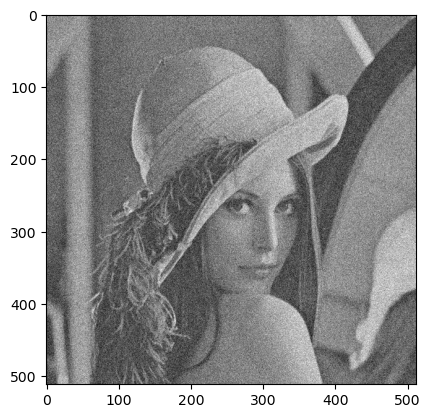

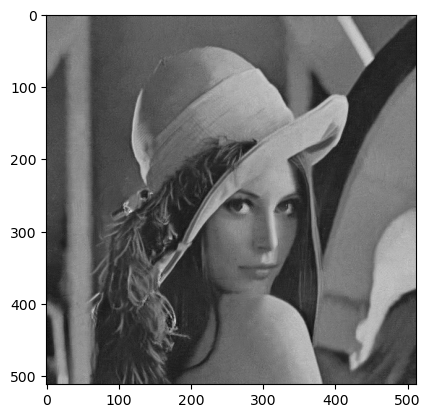

In [31]:
plt.imshow(imbr, cmap='gray')
plt.show()

plt.imshow(basic, cmap='gray')
plt.show()

In [54]:
%%time
#def bm3d_1st_step(image, sigma, kHard, nHard, lambdaHard2d, lambdaHard3d, tauHard, NHard):
image = imbr

height, width = image.shape

# pad image and iterate through original frame
window_size = nHard
offset = window_size // 2
padded_image = np.pad(image, offset, mode='reflect')

nu = np.zeros(padded_image.shape)
delta = np.zeros(padded_image.shape)

X, Y = np.meshgrid(np.arange(kHard), np.arange(kHard), indexing='ij')


# iterate through patches in the image with a step
for x in range(offset, offset + height - kHard +1 , pHard):
    for y in range(offset , offset + width - kHard +1 , pHard):
#for x in range(33,35, pHard):
 #  for y in range(534,536, pHard):

        # GROUPING
        '''
        patch = padded_image[x:x+kHard, y:y+kHard]
        search_window, x_win, y_win = get_search_window(padded_image, x, y, patch_size=kHard, window_size=nHard)

        group3d, coords = build_3d_group(x_win, y_win, patch, search_window, sigma, lambdaHard2d, tauHard, NHard)
        '''
        group3d, coords = grouping_1st_step(x, y, padded_image, sigma, patch_size=kHard, window_size=nHard, lambdaHard2d=lambdaHard2d, tauHard=tauHard, N=NHard)
        
        if len(coords) < 1:
            continue

        # COLLABORATIVE FILTERING
        # 3d transform
        transformed = np.array(apply_2d_transform(group3d, use_dct=False))
        for i in range(transformed.shape[-2]):
            for j in range(transformed.shape[-1]):
                transformed[:, i, j] = apply_1d_transform(transformed[:, i, j]) #t1d

        # thresholding
        threshold = lambdaHard3d * sigma
        thresholded = hard_thresholding(transformed, threshold)

        th_debug = thresholded

        # calculate weights
        NPHard = np.count_nonzero(thresholded)
        weight = 1/NPHard if NPHard >= 1 else 1
        weight = np.array([weight])
        

        # 3d reverse
        for i in range(thresholded.shape[-2]):
            for j in range(thresholded.shape[-1]):
                thresholded[:, i, j] = apply_1d_transform(thresholded[:, i, j]) #t1d
        
        filtered = np.array(reverse_2d_transform(thresholded, use_dct=False))

        # AGGREGATION 
        nu, delta = update_aggregation_buffers(nu, delta, filtered, np.array(coords), weight, X, Y)

## BASIC ESTIMATE
basic = np.divide(nu[offset:offset+height, offset:offset+width], delta[offset:offset+height, offset:offset+width])

#return basic

CPU times: total: 2min 14s
Wall time: 2min 55s


(512, 512)

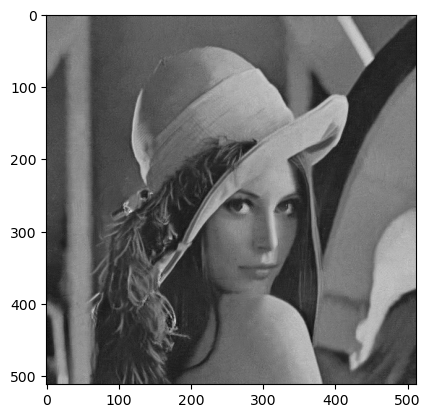

In [55]:
plt.imshow(basic,cmap='gray')
basic.shape

In [37]:
offset + height - kHard + 1

524